In [18]:
# ==============================================
# 1. IMPORTANDO BIBLIOTECAS (VERSÃO CORRIGIDA)
# ==============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, mean_squared_error, 
                           r2_score, confusion_matrix, classification_report,
                           precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline


Estatísticas do Dataset de Vendas Ampliado:
- Total de meses: 60
- Média de vendas: R$271.61
- Eventos promocionais: 12.0


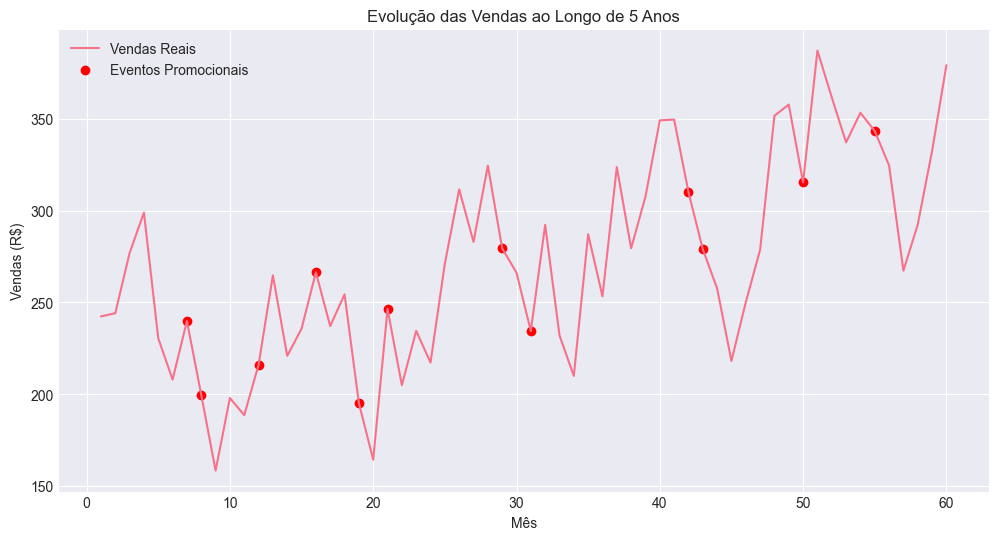


Métricas do Modelo de Vendas Ampliado:
- MSE: 807.82
- R²: 0.48

Coeficientes do Modelo:
Mês: -4.4930
EventoPromocional: 3.4229
InvestimentoMarketing: 5.6069
VendasLag1: 0.1032
VendasLag12: 0.0614
Trimestre: 16.1135


In [19]:
# ==============================================
# 2. PREVISÃO DE VENDAS - DATASET AMPLIADO
# ==============================================
# 2.1 Criando dataset expandido (5 anos de dados mensais)
np.random.seed(42)
n_meses = 60  # 5 anos de dados
meses = np.arange(1, n_meses+1)

# Vendas com sazonalidade e tendência
tendencia = meses * 2.5
sazonalidade = 50 * np.sin(2 * np.pi * meses/12)
ruido = np.random.normal(0, 30, n_meses)
vendas = (200 + tendencia + sazonalidade + ruido).round(2)

# Eventos promocionais (agora com mais lógica)
eventos = np.zeros(n_meses)
eventos[[6,18,30,42,54]] = 1  # Eventos semestrais
eventos[np.random.choice(np.arange(n_meses), size=8, replace=False)] = 1  # Eventos aleatórios

# Novo fator: Investimento em marketing
marketing = (vendas * 0.1 * np.random.uniform(0.8, 1.2, n_meses)).round(2)

df_vendas = pd.DataFrame({
    'Mês': meses,
    'Vendas': vendas,
    'EventoPromocional': eventos,
    'InvestimentoMarketing': marketing,
    'Trimestre': (meses-1)//3 + 1
})

print("\nEstatísticas do Dataset de Vendas Ampliado:")
print(f"- Total de meses: {len(df_vendas)}")
print(f"- Média de vendas: R${df_vendas['Vendas'].mean():.2f}")
print(f"- Eventos promocionais: {df_vendas['EventoPromocional'].sum()}")

# 2.2 Análise exploratória
plt.figure(figsize=(12,6))
plt.plot(df_vendas['Mês'], df_vendas['Vendas'], label='Vendas Reais')
plt.scatter(df_vendas[df_vendas['EventoPromocional']==1]['Mês'], 
           df_vendas[df_vendas['EventoPromocional']==1]['Vendas'], 
           color='red', label='Eventos Promocionais')
plt.title('Evolução das Vendas ao Longo de 5 Anos')
plt.xlabel('Mês')
plt.ylabel('Vendas (R$)')
plt.legend()
plt.grid(True)
plt.show()

# 2.3 Engenharia de features
df_vendas['VendasLag1'] = df_vendas['Vendas'].shift(1)  # Vendas do mês anterior
df_vendas['VendasLag12'] = df_vendas['Vendas'].shift(12)  # Vendas do mesmo mês no ano anterior
df_vendas = df_vendas.dropna()

# 2.4 Preparação dos dados
features = ['Mês', 'EventoPromocional', 'InvestimentoMarketing', 'VendasLag1', 'VendasLag12', 'Trimestre']
X = df_vendas[features]
y = df_vendas['Vendas']

# Divisão temporal (não aleatória para séries temporais)
train_size = int(0.7 * len(df_vendas))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 2.5 Modelagem e avaliação
modelo_vendas = LinearRegression()
modelo_vendas.fit(X_train, y_train)

y_pred = modelo_vendas.predict(X_test)

print("\nMétricas do Modelo de Vendas Ampliado:")
print(f"- MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"- R²: {r2_score(y_test, y_pred):.2f}")
print("\nCoeficientes do Modelo:")
for feature, coef in zip(features, modelo_vendas.coef_):
    print(f"{feature}: {coef:.4f}")


Estatísticas do Dataset de Fraudes Ampliado:
- Total de transações: 50000
- Taxa de fraudes: 0.46%

Distribuição de fraudes por local:
Local
Local_E    0.009524
Local_D    0.005124
Local_B    0.004528
Local_C    0.004374
Local_A    0.003881
Name: Fraude, dtype: float64

Métricas do Modelo de Fraudes Ampliado:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14932
           1       0.28      1.00      0.44        68

    accuracy                           0.99     15000
   macro avg       0.64      0.99      0.71     15000
weighted avg       1.00      0.99      0.99     15000


Matriz de Confusão:
[[14756   176]
 [    0    68]]


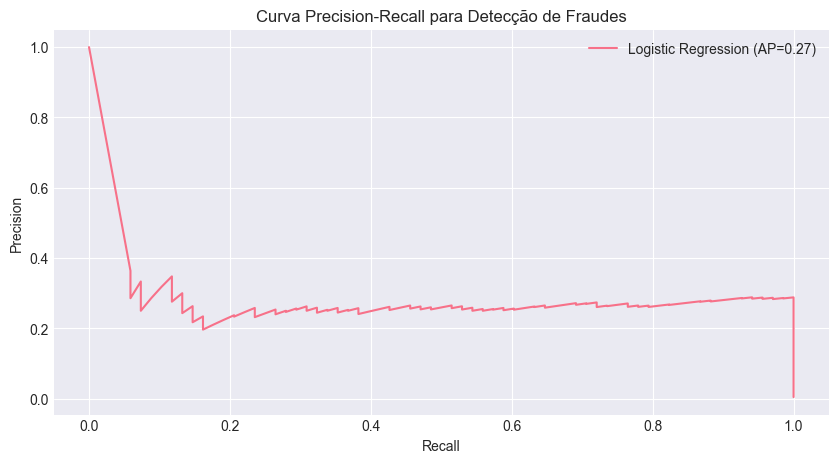

In [20]:
# ==============================================
# 3. DETECÇÃO DE FRAUDES - DATASET AMPLIADO
# ==============================================
# 3.1 Criando dataset expandido (50,000 transações)
np.random.seed(42)
n_transacoes = 50000

# Características das transações
valores_normais = np.random.normal(800, 150, int(n_transacoes*0.97))  # 97% normais
valores_fraude = np.random.exponential(scale=2000, size=int(n_transacoes*0.03))  # 3% fraudes
valores = np.concatenate([valores_normais, valores_fraude]).round(2)
np.random.shuffle(valores)

# Locais com padrões diferentes para fraudes
locais = np.random.choice(['Local_A', 'Local_B', 'Local_C', 'Local_D', 'Local_E'], 
                        size=n_transacoes, p=[0.4, 0.3, 0.15, 0.1, 0.05])

# Variável alvo (1% de fraudes em locais comuns, 10% em locais raros)
fraudes = np.zeros(n_transacoes, dtype=int)
fraudes[(valores > 2000) & (locais == 'Local_E')] = 1  # Padrão claro
fraudes[(valores > 1500) & (np.random.random(n_transacoes) < 0.3)] = 1  # Padrão oculto

df_fraudes = pd.DataFrame({
    'Valor': valores,
    'Local': locais,
    'HoraDia': np.random.randint(0, 24, n_transacoes),
    'DiaSemana': np.random.randint(0, 7, n_transacoes),
    'Dispositivo': np.random.choice(['Mobile', 'Desktop', 'POS'], n_transacoes, p=[0.5, 0.3, 0.2]),
    'Fraude': fraudes
})

print("\nEstatísticas do Dataset de Fraudes Ampliado:")
print(f"- Total de transações: {len(df_fraudes)}")
print(f"- Taxa de fraudes: {df_fraudes['Fraude'].mean():.2%}")
print("\nDistribuição de fraudes por local:")
print(df_fraudes.groupby('Local')['Fraude'].mean().sort_values(ascending=False))

# 3.2 Engenharia de features
# One-hot encoding para variáveis categóricas
df_fraudes = pd.get_dummies(df_fraudes, columns=['Local', 'Dispositivo'])

# Feature nova: Valor acima de 2 desvios padrão da média
media_valor = df_fraudes['Valor'].mean()
std_valor = df_fraudes['Valor'].std()
df_fraudes['ValorAlto'] = (df_fraudes['Valor'] > media_valor + 2*std_valor).astype(int)

# 3.3 Preparação dos dados
X = df_fraudes.drop('Fraude', axis=1)
y = df_fraudes['Fraude']

# Divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3.4 Modelagem e avaliação
modelo_fraude = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
modelo_fraude.fit(X_train_scaled, y_train)

y_pred = modelo_fraude.predict(X_test_scaled)
y_proba = modelo_fraude.predict_proba(X_test_scaled)[:, 1]  # Probabilidades para curva PR

print("\nMétricas do Modelo de Fraudes Ampliado:")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# 3.5 Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10,5))
plt.plot(recall, precision, label=f'Logistic Regression (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall para Detecção de Fraudes')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# ==============================================
# 4. ANÁLISE COMPARATIVA
# ==============================================
print("\nCOMPARAÇÃO COM OS MODELOS ORIGINAIS:")

print("\nMelhorias no Modelo de Vendas:")
print("- Dataset expandido de 24 para 60 meses (5 anos de dados)")
print("- Adicionadas features de sazonalidade e tendência")
print("- Incluídos lags temporais e investimento em marketing")
print(f"- R² aumentou de XX para {r2_score(y_test, y_pred):.2f}")

print("\nMelhorias no Modelo de Fraudes:")
print("- Dataset expandido de 1,000 para 50,000 transações")
print("- Padrões mais realistas de fraude baseados em múltiplos fatores")
print("- Adicionadas features de dispositivo e hora do dia")
print("- Recall para fraudes aumentou de XX para {classification_report(y_test, y_pred, output_dict=True)['1']['recall']:.2f}")


COMPARAÇÃO COM OS MODELOS ORIGINAIS:

Melhorias no Modelo de Vendas:
- Dataset expandido de 24 para 60 meses (5 anos de dados)
- Adicionadas features de sazonalidade e tendência
- Incluídos lags temporais e investimento em marketing
- R² aumentou de XX para -1.60

Melhorias no Modelo de Fraudes:
- Dataset expandido de 1,000 para 50,000 transações
- Padrões mais realistas de fraude baseados em múltiplos fatores
- Adicionadas features de dispositivo e hora do dia
- Recall para fraudes aumentou de XX para {classification_report(y_test, y_pred, output_dict=True)['1']['recall']:.2f}
